# Enhancing Signature-Based American Option Pricing Through Lightweight, Practical Modifications

 Signatures  

**Student**: Roshan Shah  
**Instructor**: Ms. Patel  
**Date**: 4 June 2025  

This notebook develops an efficient signature-based framework for valuing American options under rough volatility. Key features include dynamic Hurst estimation and fast signature kernel approximation, combined with both primal and dual optimal-stopping techniques.


## Project Objective
Enhance American‐option pricing under rough volatility by extending the signature‐based framework of Bayer et al. (2025).  
Our two practical contributions are:

1. **Dynamic Hurst Estimation** – Predict a time-varying sequence \(H(t)\) from rolling volatility-path signatures, replacing the fixed roughness assumption.  
2. **Fast Signature Kernels** – Use Random Fourier Features to approximate signature kernels, reducing runtime for high-dimensional paths.

We combine a **primal Longstaff–Schwartz approach** with a **dual martingale formulation**, quantify the duality gap, and benchmark computational efficiency.

---

## Table of Contents

- Parameter Estimation from Options Data  
- Signature Feature Extraction  
- Hurst Estimation Model  
- Dynamic Roughness Integration  
- Volatility Path Simulation  
- American Option Pricing (Primal)  
- American Option Pricing (Dual)  
- Evaluation and Results  
- Future Work  



# Pricing American Options in Rough Bergomi

## Using Linear and Deep Signature Methods

---

*Part of the [Optimal Stopping with Signatures](https://github.com/roshanshah11/Optimal_Stopping_with_signatures) project*

---

> **Project Overview:**  
> This notebook applies **signature-based methods** to solve **optimal stopping problems** in **non-Markovian settings**, with a focus on pricing American options under **rough volatility**.  
> 
> **Primary Reference:**  
> [Optimal Stopping with Signatures (arXiv:2312.03444)](https://arxiv.org/abs/2312.03444) by Bayer, Pelizzari, and Schoenmakers (2025)

---

## Implementation Summary

This implementation improves the framework proposed by Bayer et al. by introducing two key practical enhancements:

- **Dynamic Hurst Estimation**  
  A gradient-boosted regression model predicts a sequence of time-varying Hurst parameters \( H(t) \) from rolling volatility path signatures.

- **Fast Signature Kernel Approximation**  
  Signature-kernel computations are accelerated using **Random Fourier Features**, making high-dimensional paths (N > 100) tractable.

We implement both:

- **Primal pricing** using Longstaff-Schwartz regression over signature features  
- **Dual pricing** using martingale representations parameterized by the path signature

---



# Repository Overview

> This notebook demonstrates the code from [the Optimal Stopping with Signatures repository](https://github.com/lucapelizzari/Optimal_Stopping_with_signatures/tree/main) to compute lower and upper bounds for American options in the rough Bergomi model using signature methods. The linear approach is described in Section 4.2 of [the accompanying paper](https://arxiv.org/abs/2312.03444), while the deep neural network approaches will be discussed in a forthcoming paper.

## Repository Contents

The codebase includes:

* **Simulation packages** for fractional Brownian motion, rough Bergomi and rough Heston models
  
* **Signature computation module** (`Signature_computer.py`) - Computes signature and log-signature of various lifts related to volatility modeling, with options to add polynomials of the state-process and/or volatility

* **Linear signature module** (`Linear_signature_optimal_stopping.py`) - Derives lower and upper bounds to the optimal stopping problem using the approaches described in [the paper](https://arxiv.org/abs/2312.03444)

* **Deep log-signature module** (`Deep_signature_optimal_stopping.py`) - Extends the linear approaches by applying deep neural networks on the log-signature, accompanying a working paper on "American option pricing using signatures"



# Section 1: Parameter Estimation From Options Data

---

## *A step-by-step guide to estimate rough volatility model parameters from options data*

---

Let's dive in!

---


## 1.1 Importing Required Libraries
<div style="border-left: 5px solid #4472C4; padding-left: 10px;">
First, we'll import the necessary Python libraries for data handling, numerical computations, and file operations.
</div>

In [293]:
import numpy as np
import pandas as pd
import os
import logging
from pathlib import Path

## 1.2 Initializing Global Parameters

> **Model Parameters**
>
> Here we set up placeholders for our model parameters. These will be populated later in the notebook based on our analysis.

| Parameter | Description |
|-----------|-------------|
| `N1`, `N`, `T` | Time discretization parameters |
| `M`, `M2` | Monte Carlo simulation parameters |
| `eta` | Volatility of volatility parameter |
| `X0` | Initial asset price (forward price) |
| `r` | Risk-free interest rate |
| `rho` | Correlation between asset returns and volatility |
| `xi` | Initial variance value |
| `strike` | Option strike price |
| `K` | Model calibration parameter |

### 1.3 The Payoff Function

> For put options, the payoff function determines the final value of the option at expiration. It returns the maximum of (strike price - asset price) or zero.
>
> $\text{Payoff} = \max(K - S_T, 0)$
>
> where $K$ is the strike price and $S_T$ is the asset price at expiration

In [294]:
# Global option model parameters (pre-initialized)
N1 = 0
N = 0
T = 0
T_years = 0.0
M = 0
M2 = 0
eta = 0.0
X0 = 0.0
r = 0.0
rho = 0.0
xi = 0.0
strike = 0.0
K = 0
Hurst_list = []

def phi(x):
    return np.maximum(strike - x, 0)


Paths/ Loading_Cleaning the data:

## 1.4 Setting Up File Paths / Data Loading Function

> **File Path Configuration**  
> Now we define the file paths for our data. We use Path from the pathlib library to ensure cross-platform compatibility.

> **Data Loading Function**  
> This function handles loading the price dataset. It checks if a cached version exists (for faster loading) and otherwise loads from CSV.



In [295]:
# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Paths
repo_root = os.path.abspath('..')
notebook_dir = Path(repo_root) / 'XGboost_Roshan' / 'src'
DATA_PICKLE = notebook_dir / 'data' / 'dataset1.pkl'
RETURNS_PICKLE = notebook_dir / 'data' / 'dataset3.pkl'

def load_and_clean_data(pickle_path):
    if os.path.exists(pickle_path):
        logger.info(f"Loading data from {pickle_path}")
        df = pd.read_pickle(pickle_path)
    else:
        logger.warning(f"Pickle file not found at {pickle_path}")
        os.makedirs(pickle_path.parent, exist_ok=True)
        csv_path = pickle_path.with_suffix('.csv')
        if os.path.exists(csv_path):
            logger.info(f"Found CSV at {csv_path}. Converting to pickle.")
            df = pd.read_csv(csv_path, parse_dates=['date'], dayfirst=False)
            df.to_pickle(pickle_path)
            logger.info(f"Converted and saved as pickle: {pickle_path}")
        else:
            logger.warning(f"CSV file also not found at {csv_path}")
            return None

    if 'secid' in df.columns or 'index_flag' in df.columns:
        df = df.drop(columns=['secid', 'index_flag'], errors='ignore')
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

    logger.info(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns from {pickle_path.name}")
    return df

def select_data_by_date_and_days(df, target_date=None, days_length=None):
    filtered_df = df.copy()
    if target_date:
        filtered_df = filtered_df[filtered_df['date'] == pd.to_datetime(target_date)]
    if days_length is not None:
        filtered_df = filtered_df[filtered_df['days'] == days_length]
    return filtered_df


def extract_model_inputs(option_df):
    put_df = option_df[option_df['cp_flag'] == 'P']
    if put_df.empty:
        return None
    row = put_df.iloc[0]
    return {
        "ticker": row['ticker'],
        "date": row['date'],
        "T_years": row['days'] / 252,
        "strike": row['strike_price'],
        "X0 (forward)": row['forward_price'],
        "market_premium": row['premium']
    }

## 1.5 Parameter Estimation Functions

> Now we'll define functions to estimate two critical model parameters for rough volatility models:

### Parameter: ρ (rho)

| Aspect | Description |
|--------|-------------|
| **Meaning** | Correlation between returns and volatility |
| **Formula** | $\rho = \text{Corr}(r_t, \Delta \sigma_t)$ |

### Parameter: η (eta)

| Aspect | Description |
|--------|-------------|
| **Meaning** | Volatility of volatility |
| **Formula** | $\eta = \frac{\text{std}(\Delta \log \sigma_t)}{(\Delta t)^H}$ |

> **Note on Hurst Exponent**: We use a rolling Hurst exponent $(H)$ in the denominator of η to reflect local path roughness, which we calculated using [`train_hurst.py`](../../Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/train_hurst.py)

---

These parameters are crucial for capturing the dynamics of financial markets accurately.

---


In [296]:
def estimate_rho(returns_df, options_df, target_ticker, target_date, days_length):
    ret_df = returns_df[(returns_df['ticker'] == target_ticker) & (returns_df['date'] <= target_date)].copy()
    opt_df = options_df[(options_df['ticker'] == target_ticker) & 
                        (options_df['cp_flag'] == 'P') & 
                        (options_df['days'] == days_length) & 
                        (options_df['date'] <= target_date)].copy()

    ret_df = ret_df.sort_values('date')
    opt_df = opt_df.sort_values('date').drop_duplicates(subset=['date'])

    merged = pd.merge(ret_df, opt_df[['date', 'impl_volatility']], on='date', how='inner')
    merged['vol_change'] = merged['impl_volatility'].diff()
    merged = merged.dropna(subset=['return', 'vol_change'])

    if len(merged) < 2:
        return None
    return merged['return'].corr(merged['vol_change'])

def compute_rolling_hurst(returns: np.ndarray, power: int) -> np.ndarray:
    if not isinstance(returns, np.ndarray):
        returns = np.array(returns)
    n = 2**power
    if len(returns) < n:
        raise ValueError(f"Need at least {n} data points for power={power}")
    hursts = []
    exponents = np.arange(2, power+1)
    for t in range(n, len(returns) + 1):
        window = returns[t-n:t]
        rs_log = []
        for exp in exponents:
            m = 2**exp
            s = n // m
            segments = window.reshape(s, m)
            dev = np.cumsum(segments - segments.mean(axis=1, keepdims=True), axis=1)
            R = dev.max(axis=1) - dev.min(axis=1)
            S = segments.std(axis=1)
            rs = np.where(S != 0, R/S, 0)
            rs_log.append(np.log2(rs.mean()))
        hursts.append(np.polyfit(exponents, rs_log, 1)[0])
    return np.array(hursts)

def estimate_eta_and_xi(option_df, hurst):
    option_df = option_df.sort_values('date').drop_duplicates(subset=['date'])
    option_df['log_vol'] = np.log(option_df['impl_volatility'])
    option_df['log_vol_diff'] = option_df['log_vol'].diff()
    std_log_vol_diff = option_df['log_vol_diff'].dropna().std()
    delta_t = 1 / 252
    eta = std_log_vol_diff / (delta_t ** hurst + 0.5)
    xi = option_df['impl_volatility'].iloc[0] ** 2 if not option_df['impl_volatility'].isnull().all() else 0.0
    return eta, xi


## 1.6 Main Analysis Process for Determining the Parameters

> This section defines our main analysis function that brings everything together. This function performs the following steps:

1. **Filter the option data** by ticker, date, and days to maturity
2. **Extract model inputs** from the filtered put options
3. **Estimate the correlation (ρ)** between returns and volatility
4. **Compute the latest Hurst exponent (H)** for the roughness of volatility
5. **Estimate volatility parameters** (η and ξ)
6. **Set up all required** model configuration parameters

---

*The analysis process creates a comprehensive pipeline that transforms raw option data into calibrated model parameters for the rough volatility model.*

In [297]:
if __name__ == "__main__":
    df = load_and_clean_data(DATA_PICKLE)
    returns_df = load_and_clean_data(RETURNS_PICKLE)

    if df is not None and returns_df is not None:
        date_input = input("Enter date (YYYY-MM-DD) from 2022-08-31 to 2023-08-31 [default: 2023-08-31]: ").strip()
        target_date = pd.to_datetime(date_input if date_input else "2023-08-31")

        days_input = input("Enter option length in days(Either 10,30,60, 91, 122,152,182,273,365,547,730) [default: 10]: ").strip()
        try:
            days_length = int(days_input) if days_input else 10
        except ValueError:
            logger.warning("Invalid input for days. Defaulting to 10.")
            days_length = 10

        ticker_input = input("Enter ticker (Either: AAPL, TSLA, JPM, AMD, META) [default: AAPL]: ").strip().upper()
        ticker = ticker_input if ticker_input else "AAPL"

        filtered_data = select_data_by_date_and_days(df, target_date, days_length)
        ticker_data = filtered_data[filtered_data['ticker'] == ticker]

        if len(ticker_data) > 0:
            print(f"\nFiltered data for {ticker} on {target_date.date()} with {days_length} days:")
            print(ticker_data)
            model_inputs = extract_model_inputs(ticker_data)
            if model_inputs:
                print("\n Extracted Model Inputs (PUTS):")
                for k, v in model_inputs.items():
                    print(f"{k}: {v}")

                rho_est = round(estimate_rho(returns_df, df, ticker, target_date, days_length), 2)
                print(f"Estimated rho: {rho_est}" if rho_est is not None else "Rho estimation failed.")
                rho = rho_est if rho_est is not None else -0.9

                rets = returns_df[(returns_df['ticker'] == ticker) & (returns_df['date'] <= target_date)]
                rets = rets.sort_values('date')['return'].values
                hurst_values = compute_rolling_hurst(rets, power=5)
                hurst_dates = returns_df[(returns_df['ticker'] == ticker) & (returns_df['date'] <= target_date)].sort_values('date').iloc[2**5 - 1:]['date'].values
                hurst_df = pd.DataFrame({'date': hurst_dates, 'H': hurst_values})
                H_df = hurst_df[hurst_df['date'] <= target_date]
                latest_H = H_df.iloc[-1]['H'] if not H_df.empty else 0.1
                print(f"Using Hurst: {round(latest_H, 3)}")

                iv_path_df = df[
                    (df['ticker'] == ticker) &
                    (df['cp_flag'] == 'P') &
                    (df['days'] == days_length) &
                    (df['date'] <= target_date)
                ].sort_values('date')

                eta, xi = estimate_eta_and_xi(iv_path_df, hurst=latest_H)
                eta = round(eta, 3)
                xi = round(xi, 5)

                N = 252
                M = 2**15
                M2 = 2**15
                
                
                r = 0.05
                K = 3

                T = int(model_inputs["T_years"] * 252)
                N1 = T
                premium = model_inputs["market_premium"]
                T_years = model_inputs["T_years"]
                X0 = model_inputs["X0 (forwa" \
                "rd)"]
                strike = model_inputs["strike"]

                print("\n✅ Global parameters set:")
                print(f"N1 = {N1}, N = {N}, T = {T}, T_years = {T_years:.5f}")
                print(f"M = {M}, M2 = {M2}, eta = {eta}, X0 = {X0}, strike = {strike}")
                print(f"r = {r}, rho = {rho}, xi = {xi}, K = {K}")
            else:
                logger.warning("No put option found for this filter.")
        else:
            logger.warning("No data matches your filter criteria.")

2025-06-06 00:21:54,205 - INFO - Loading data from /Users/roshanshah1/Downloads/Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/data/dataset1.pkl
2025-06-06 00:21:54,220 - INFO - Loaded 55440 rows and 8 columns from dataset1.pkl
2025-06-06 00:21:54,221 - INFO - Loading data from /Users/roshanshah1/Downloads/Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/data/dataset3.pkl
2025-06-06 00:21:54,229 - INFO - Loaded 124798 rows and 4 columns from dataset3.pkl



Filtered data for META on 2023-08-31 with 10 days:
            date  days  forward_price  strike_price   premium  \
55418 2023-08-31    10     296.297047    296.297047  6.017835   
55429 2023-08-31    10     296.297047    296.297047  5.611737   

       impl_volatility cp_flag ticker  
55418          0.30801       C   META  
55429          0.28589       P   META  

 Extracted Model Inputs (PUTS):
ticker: META
date: 2023-08-31 00:00:00
T_years: 0.03968253968253968
strike: 296.297047
X0 (forward): 296.297047
market_premium: 5.611737
Estimated rho: -0.12
Using Hurst: 0.587

✅ Global parameters set:
N1 = 10, N = 252, T = 10, T_years = 0.03968
M = 32768, M2 = 32768, eta = 0.206, X0 = 296.297047, strike = 296.297047
r = 0.05, rho = -0.12, xi = 0.19736, K = 3


> ## 📋 Parameter Verification Note
> 
> This cell displays a comprehensive summary of all global parameters after initialization:
>
> ### Time Parameters
> - **N1, N**: Discretization points
> - **T, T_years**: Time horizon in units and years
>
> ### Simulation Parameters
> - **M**: Monte Carlo sample size (training)
> - **M2**: Monte Carlo sample size (testing)
>
> ### Volatility Model Parameters
> - **eta**: Volatility of volatility
> - **xi**: Initial variance
> - **rho**: Correlation between price and volatility
>
> ### Option Parameters
> - **X0**: Initial forward price
> - **strike**: Option strike price
> - **r**: Risk-free interest rate
>
> ### Model Parameters
> - **K**: Calibration parameter
>
> *Always verify these values before proceeding with calculations to ensure correct model behavior.*

In [298]:
print(f"n1 = {N1}, n = {N}, T = {T}, T_years = {T_years:.5f}, M = {M}, M2 = {M2}, eta = {eta:}, X0 = {X0:.5f}, strike = {strike:.5f}, r = {r:.5f}, rho = {rho:.5f}, xi = {xi:.5f}, K = {K}")

n1 = 10, n = 252, T = 10, T_years = 0.03968, M = 32768, M2 = 32768, eta = 0.206, X0 = 296.29705, strike = 296.29705, r = 0.05000, rho = -0.12000, xi = 0.19736, K = 3


In [299]:
# Fix for TensorFlow import issues and environment compatibility
# Set correct Python path to find modules
import sys
import os

# Add the root directory and subdirectories to Python path
repo_root = os.path.abspath('..')
sys.path.append(repo_root)
sys.path.append(os.path.join(repo_root, "Linear signature optimal stopping"))
sys.path.append(os.path.join(repo_root, "Non linear signature optimal stopping"))

# Suppress TensorFlow warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Now I will Estimating my Hurst Parameter:

# Section 2: XGBoost for Hurst Exponent Forecasting (over multiple days)

This notebook provides a detailed walkthrough of [`train_hurst.py`](../../Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/train_hurst.py), a script that computes the rolling Hurst exponent of a time series and trains/evaluates an XGBoost model to forecast its future values.

## What is the Hurst Exponent?

> The Hurst exponent is a measure used in time series analysis that quantifies the long-term memory of a series. It helps determine if a time series is:
> - **H < 0.5**: Anti-persistent (mean-reverting)
> - **H = 0.5**: Random walk (no memory)
> - **H > 0.5**: Trend-reinforcing (persistent)

## Table of Contents

- [2.1 Library Imports and Configuration Setup](#section-2-1)
- [2.2 Computing the Rolling Hurst Exponent](#section-2-2)
- [2.3 Loading and Preparing Financial Data](#section-2-3)
- [2.4 Creating Lagged Features for Time Series Forecasting](#section-2-4)
- [2.5 Training the XGBoost Model for Hurst Prediction](#section-2-5)
- [2.6 Evaluating the XGBoost Model Performance](#section-2-6)
- [2.7 Forecasting Future Hurst Exponents](#section-2-7)
- [2.8 Main Function for Hurst Analysis](#section-2-8)
- [2.8 Run the Main Function](#section-2-9)

Let's get started!

*Last updated: 2025-05-20 15:08:45 UTC by roshanshah11*

<a id="section-2-1"></a>

## 2.1 Library Imports and Configuration Setup

This section imports all necessary Python libraries required for the Hurst exponent calculation and XGBoost forecasting, including:

- **Numerical & Data Processing**: NumPy, Pandas
- **Visualization**: Matplotlib 
- **File System**: Pathlib
- **Machine Learning**: XGBoost, Scikit-learn metrics
- **Utilities**: Logging, Joblib

The configuration section establishes:
- Forecast horizon settings
- Logging configuration
- Model storage directories

> The code below sets up the foundation for all subsequent analysis and model building steps.

In [300]:
# Import necessary libraries for numerical operations, data manipulation, and visualization
import numpy as np                # For numerical computations (arrays, math functions)
import pandas as pd               # For data manipulation with DataFrames
import matplotlib.pyplot as plt   # For creating plots and visualizations
from pathlib import Path          # For handling file paths in a platform-independent way
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For model evaluation metrics
import logging                    # For logging status and debug messages
import joblib                     # For saving/loading Python objects (like our trained models)
from xgboost import XGBRegressor  # XGBoost regression model implementation

# Set up basic configuration
# How many days ahead to predict (forecast horizon)
HORIZON = T

# Configure logging to show informational messages with timestamps
logging.basicConfig(
    level=logging.INFO,  # Show INFO level messages and above
    format='%(asctime)s - %(levelname)s - %(message)s'  # Include timestamp and message level
)
logger = logging.getLogger(__name__)

# Create directory for saving trained models
MODELS_DIR = notebook_dir / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

print(f"Models will be stored in: {MODELS_DIR}")

Models will be stored in: /Users/roshanshah1/Downloads/Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/models


<a id="section-2-2"></a>

## 2.2 Computing the Rolling Hurst Exponent

This function calculates the Hurst exponent using Rescaled Range (R/S) analysis over a rolling window. The Hurst exponent measures the long-term memory or persistence of a time series.

> 🔑 **Key Concepts:**
> - **Window size**: 2^power determines how many data points we use for each calculation
> - **R/S Analysis**: Calculates the ratio of the range to the standard deviation at different time scales
> - **Slope of log-log plot**: The slope of the line relating log(R/S) to log(time scale) gives us the Hurst exponent

In [301]:
def compute_rolling_hurst(returns: np.ndarray, power: int) -> np.ndarray:
    """
    Calculate the Hurst exponent using R/S analysis over
    a rolling window of size 2^power.
    """
    # here is a source i used: https://en.wikipedia.org/wiki/Hurst_exponent
    # Ensure returns are in numpy array form
    if not isinstance(returns, np.ndarray):
        returns = np.array(returns)
    # Validate 'power' parameter
    if not isinstance(power, int) or power < 1:
        raise ValueError("power must be a positive integer")
    # Window length = 2^power
    n = 2**power
    if len(returns) < n:
        raise ValueError(f"Need at least {n} data points for power={power}")
    hursts = []                          # list to collect Hurst exponents
    exponents = np.arange(2, power+1)    # scales for R/S calculation
    # Slide the window through the data
    for t in range(n, len(returns) + 1):
        window = returns[t-n:t]          # current data chunk
        rs_log = []                      # log2 of rescaled range values
        for exp in exponents:
            # split window into segments and compute R/S per segment
            m = 2**exp
            s = n // m
            segments = window.reshape(s, m)
            dev = np.cumsum(
                segments - segments.mean(axis=1, keepdims=True),
                axis=1
            )
            R = dev.max(axis=1) - dev.min(axis=1)
            S = segments.std(axis=1)
            rs = np.where(S != 0, R/S, 0)
            rs_log.append(np.log2(rs.mean()))
        # linear fit: slope ≈ Hurst exponent
        hursts.append(np.polyfit(exponents, rs_log, 1)[0])
    return np.array(hursts)


<a id="section-2-3"></a>

## 2.3 Loading and Preparing Financial Data

This section implements the data loading functionality that retrieves price data for our Hurst exponent calculations. The function loads data efficiently by:

1. First checking for a cached version of the dataset
2. Loading from the faster pickle format when available
3. Otherwise processing and sorting the data by date
4. Creating a cache for future use

> The `load_data()` function returns a pandas DataFrame containing all necessary price data for our time series analysis, properly sorted chronologically for accurate Hurst exponent calculation.

In [302]:
def load_data() -> pd.DataFrame:
    """
    Load the price dataset from CSV or cache, sort by date,
    and return a pandas DataFrame.
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing price data sorted by date
    """
    # First, check if a cached (pickled) version of the data exists
    if RETURNS_PICKLE.exists():
        # Load from the pickle file (much faster than CSV)
        df = pd.read_pickle(RETURNS_PICKLE)
        logger.info(f"Loaded data from cache: {RETURNS_PICKLE}")
    else:
        # Sort the data by date
        df.sort_values('date', inplace=True)
        
        # Cache the data for faster future loading
        df.to_pickle(RETURNS_PICKLE)
        logger.info(f"Saved data to cache: {RETURNS_PICKLE}")
        
    return df

<a id="section-2-4"></a>

## 2.4 Creating Lagged Features for Time Series Forecasting

This function creates lagged features for time series forecasting. Lagged features are simply past values of the time series that are used to predict future values.

### Key Concepts:

| Concept | Description |
|---------|-------------|
| **Lag** | Using past values (t-1, t-2, ..., t-k) to predict the current value (t) |
| **Feature Matrix X** | Each row contains k consecutive past values |
| **Target Vector y** | Contains the value we want to predict (the value at time t) |

In [303]:
def make_lagged_features(series: pd.Series, k: int):
    """
    Generate lagged features matrix X and target vector y from a time series.
    
    Parameters:
    -----------
    series : pd.Series
        Time series data to create lagged features from
    k : int
        Number of lagged values to use as features
        
    Returns:
    --------
    (np.ndarray, np.ndarray)
        X: Feature matrix where each row contains k consecutive past values
        y: Target vector containing the values to predict
    """
    # Convert series to a numpy array for faster processing
    vals = series.values
    
    # Initialize empty lists for features and targets
    X, y = [], []
    
    # For each point in the time series (starting from position k)
    for i in range(k, len(vals)):
        # Add the k previous values as features
        X.append(vals[i-k:i])
        # Add the current value as the target
        y.append(vals[i])
    
    # Convert lists to numpy arrays and return
    return np.array(X), np.array(y)

<a id="section-2-5"></a>

## 2.5 Training the XGBoost Model for Hurst Prediction

This section defines the function for training a standalone XGBoost regression model on the time series of Hurst exponents. The training process follows these key steps:

1. **Temporal Data Splitting** - Divides the Hurst exponent time series into training and testing sets based on chronological order
2. **Feature Engineering** - Creates lagged features from the training data using the previously defined function
3. **Model Training** - Initializes and fits an XGBoost regressor with the provided hyperparameters
4. **Model Persistence** - Saves the trained model to disk for later prediction use

> The XGBoost model learns patterns in the Hurst exponent's temporal evolution, allowing us to forecast how market roughness will change in future periods.

In [304]:
def train_multi_step_xgb(hurst_series: pd.Series, train_frac: float, k: int, horizon: int, xgb_params: dict):
    """Train multiple XGBoost models to predict all steps in the forecast horizon at once."""
    split = int(len(hurst_series) * train_frac)
    train = hurst_series.iloc[:split]
    values = train.values
    
    # Create separate models for each step in the forecast horizon
    models = []
    
    for step in range(horizon):
        X, y = [], []
        # For each forecast step, create appropriate training examples
        for i in range(k, len(values) - step):
            X.append(values[i-k:i])
            y.append(values[i+step])  # Target is 'step' days ahead
            
        X = np.array(X)
        y = np.array(y)
        
        # Train model for this specific forecast step
        model = XGBRegressor(**xgb_params)
        model.fit(X, y)
        models.append(model)
        logger.info(f"Trained model for step {step+1}/{horizon}")
    
    # Save the models
    joblib.dump(models, MODELS_DIR / f'xgb_multi_step_{horizon}.pkl')
    logger.info(f"Multi-step XGBoost models saved to {MODELS_DIR}")
    
    return models

<a id="section-2-6"></a>

## 2.6 Evaluating the XGBoost Model Performance

This section implements the evaluation framework for our trained XGBoost model. The function performs a comprehensive assessment through:

1. **Time-based Test Split** - Uses the most recent portion of the Hurst exponent time series for out-of-sample testing
2. **Feature Generation** - Creates the same lagged feature structure for test data as was used in training
3. **Performance Metrics** - Calculates both Mean Squared Error (MSE) and Mean Absolute Error (MAE)
4. **Visual Validation** - Plots actual vs. predicted Hurst exponent values over time

> The evaluation provides quantitative metrics and visual confirmation of how well our model can forecast future Hurst exponent values, which is critical for assessing market roughness dynamics.

In [305]:
def evaluate_multi_step_xgb(hurst_series: pd.Series, models: list, k: int, test_frac: float, horizon: int):
    """Evaluate multi-step XGBoost models on test split and plot results."""
    split = int(len(hurst_series) * (1 - test_frac))
    test = hurst_series.iloc[split:]
    
    # Calculate the actual values for each forecast step
    actuals = []
    for step in range(horizon):
        if step < len(test) - k:
            actual_vals = test.iloc[k+step:].values
            actuals.append(actual_vals)
        else:
            actuals.append([])
    
    # Calculate predictions for each step
    predictions = []
    for step, model in enumerate(models):
        if step < horizon:
            X_test = []
            for i in range(k, len(test) - step):
                X_test.append(test.iloc[i-k:i].values)
            
            if X_test:
                X_test = np.array(X_test)
                preds = model.predict(X_test)
                predictions.append(preds)
            else:
                predictions.append([])
    
    # Calculate error metrics for each step
    mse_values = []
    mae_values = []
    for step in range(horizon):
        if len(actuals[step]) > 0 and len(predictions[step]) > 0:
            min_len = min(len(actuals[step]), len(predictions[step]))
            mse = mean_squared_error(actuals[step][:min_len], predictions[step][:min_len])
            mae = mean_absolute_error(actuals[step][:min_len], predictions[step][:min_len])
            mse_values.append(mse)
            mae_values.append(mae)
            logger.info(f"Step {step+1} - MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    # Plot results for multiple steps
    plt.figure(figsize=(14, 7))
    dates_test = test.index[k:]
    plt.plot(dates_test, test.iloc[k:].values, 'k-', label='Actual Hurst')
    
    # Assuming horizon is defined earlier
    colors = [tuple(np.random.random(3)) for _ in range(horizon)]  # Generate as tuples, not lists

    for step in range(horizon):
        if len(predictions[step]) > 0:
            forecast_dates = dates_test[:len(predictions[step])]
            plt.plot(forecast_dates, 
                    predictions[step], 
                    color=colors[step],  # Use color parameter instead of format string
                    label=f'Step {step+1} Forecast')
    
    plt.title('Multi-Step XGBoost: Actual vs Forecast Hurst Exponent')
    plt.xlabel('Date')
    plt.ylabel('Hurst Exponent')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return np.mean(mse_values), np.mean(mae_values)

<a id="section-2-7"></a>

## 2.7 Forecasting Future Hurst Exponents

This section implements the forecasting functionality that generates predictions for future Hurst exponent values. The function creates multi-step forecasts by:

1. **Recursive Prediction** - Using each prediction as input for subsequent predictions
2. **Historical Context** - Maintaining a sliding window of the most recent k values
3. **Business Calendar** - Generating forecasts for business days only
4. **Structured Output** - Returning results in a DataFrame with dates and forecasted values

> The forecasting process enables us to project future market roughness characteristics, providing valuable insight for trading strategies and risk management.

In [306]:
def forecast_multi_step_xgb(hurst_series: pd.Series, models: list, periods: int, k: int):
    """Generate all future forecasts at once using the multi-step models."""
    # Get the most recent window of data
    last_window = hurst_series.values[-k:]
    
    # Generate predictions for each step using its own model
    predictions = []
    for step in range(min(periods, len(models))):
        model = models[step]
        pred = model.predict(last_window.reshape(1, -1))[0]
        predictions.append(pred)
    
    # If we need more predictions than we have models for
    while len(predictions) < periods:
        predictions.append(predictions[-1])  # Just repeat the last prediction
    
    dates = pd.date_range(hurst_series.index[-1] + pd.Timedelta(days=1), 
                         periods=periods, freq='B')
    
    return pd.DataFrame({'ds': dates, 'yhat': np.array(predictions)})

<a id="section-2-8"></a>

## 2.8 Main Execution Function for Hurst Analysis

This section defines the main orchestration function that brings together all previous components into a complete Hurst exponent analysis pipeline. The function:

1. **Initializes Parameters** - Sets key configuration values for window size, feature count, and model parameters
2. **Processes Data** - Loads and filters price data for the target ticker
3. **Computes Historical Hurst** - Calculates rolling Hurst exponent values from return data
4. **Executes Complete Workflow** - Sequentially runs training, evaluation, and forecasting
5. **Visualizes Results** - Plots historical and forecasted Hurst values for interpretation
6. **Returns Forecast** - Provides the list of forecasted Hurst values for further use

> This comprehensive function encapsulates the entire workflow from raw return data to visualized Hurst forecasts, enabling efficient execution of the roughness analysis process.

In [307]:
def main_hurst():
    """
    Main entry point: show menu, get user choice, compute Hurst series,
    and train/evaluate/forecast the XGBoost model as requested.
    """

    # Log start of execution
    logger.info("Starting main execution...")
    # for the sake of this example, we will use a fixed mode
    power = 5
    train_frac, test_frac = 0.8, 0.2
    k = 5
    xgb_params = {'n_estimators': 100, 'learning_rate': 0.1}
    periods = HORIZON

    # Load data and filter by ticker symbol
    df_all = load_data()
    df_t = df_all[df_all['ticker'] == ticker].sort_values('date')
    returns = df_t['return'].values

    # Compute rolling Hurst exponent series
    hurst_vals = compute_rolling_hurst(returns, power)
    dates = df_t['date']
    start_index = 2**power - 1
    hurst_series = pd.Series(hurst_vals, index=dates[start_index:])

    #it will first train the model, then evaluate, and finally forcase
    multi_models = train_multi_step_xgb(hurst_series, train_frac, k, periods, xgb_params)
        # Evaluate multi-step model
    try:
        multi_models = joblib.load(MODELS_DIR / f'xgb_multi_step_{periods}.pkl')
        mse, mae = evaluate_multi_step_xgb(hurst_series, multi_models, k, test_frac, periods)
        logger.info(f"Multi-step XGBoost results - Average MSE: {mse:.4f}, Average MAE: {mae:.4f}")
    except FileNotFoundError:
        logger.error(f"Multi-step model file not found. Please train the model first.")
    try:
        multi_models = joblib.load(MODELS_DIR / f'xgb_multi_step_{periods}.pkl')
        df_fc = forecast_multi_step_xgb(hurst_series, multi_models, periods, k)
        logger.info("Multi-step XGBoost forecast:\n%s", df_fc)
            
        plt.figure(figsize=(12,6))
        plt.plot(hurst_series.index, hurst_series.values, 'k-', label='Historical Hurst')
        plt.plot(df_fc['ds'], df_fc['yhat'], 'r--', label='Multi-step Forecast')
        plt.title(f'{periods}-Day Multi-step Hurst Forecast for {ticker}')
        plt.xlabel('Date'); plt.ylabel('Hurst Exponent')
        plt.legend(); plt.grid(True)
        plt.xticks(rotation=45); plt.tight_layout(); plt.show()
    except FileNotFoundError:
        logger.error(f"Multi-step model file not found. Please train the model first.")
    print("List of hurst parameters:", list(df_fc['yhat']))
    logger.info("XGBoost-only forecast:\n%s", df_fc)
    return list(list(df_fc['yhat']))

<a id="section-2-9"></a>

## 2.9 Hurst Analysis Output

When we execute the main_hurst() function, it produces the following results:

1. **Forecasted Hurst Values** - A list of numerical values representing the predicted Hurst exponents for the next 10 business days is displayed in the console output
   
2. **Visualization** - A time series plot appears showing:
   - Historical Hurst exponent values in black solid line
   - Forecasted Hurst exponents in green dashed line
   - Clear title indicating the forecast horizon and ticker symbol
   - Properly labeled axes and legend

3. **Console Log** - Detailed information about the forecast is recorded in the application logs

4. **Return Value** - The Hurst_list variable now contains the array of forecasted values for use in subsequent trading strategy optimization

> The output provides both visual and numerical representations of how market roughness is expected to evolve, allowing traders to adjust their strategies according to anticipated market conditions.

*Generated: 2025-05-20 15:12:01 UTC by roshanshah11*

2025-06-06 00:21:58,072 - INFO - Starting main execution...
2025-06-06 00:21:58,080 - INFO - Loaded data from cache: /Users/roshanshah1/Downloads/Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/data/dataset3.pkl
2025-06-06 00:21:58,228 - INFO - Trained model for step 1/10
2025-06-06 00:21:58,352 - INFO - Trained model for step 2/10
2025-06-06 00:21:58,475 - INFO - Trained model for step 3/10
2025-06-06 00:21:58,600 - INFO - Trained model for step 4/10
2025-06-06 00:21:58,716 - INFO - Trained model for step 5/10
2025-06-06 00:21:58,840 - INFO - Trained model for step 6/10
2025-06-06 00:21:58,961 - INFO - Trained model for step 7/10
2025-06-06 00:21:59,083 - INFO - Trained model for step 8/10
2025-06-06 00:21:59,206 - INFO - Trained model for step 9/10
2025-06-06 00:21:59,327 - INFO - Trained model for step 10/10
2025-06-06 00:21:59,337 - INFO - Multi-step XGBoost models saved to /Users/roshanshah1/Downloads/Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/models
2025-06

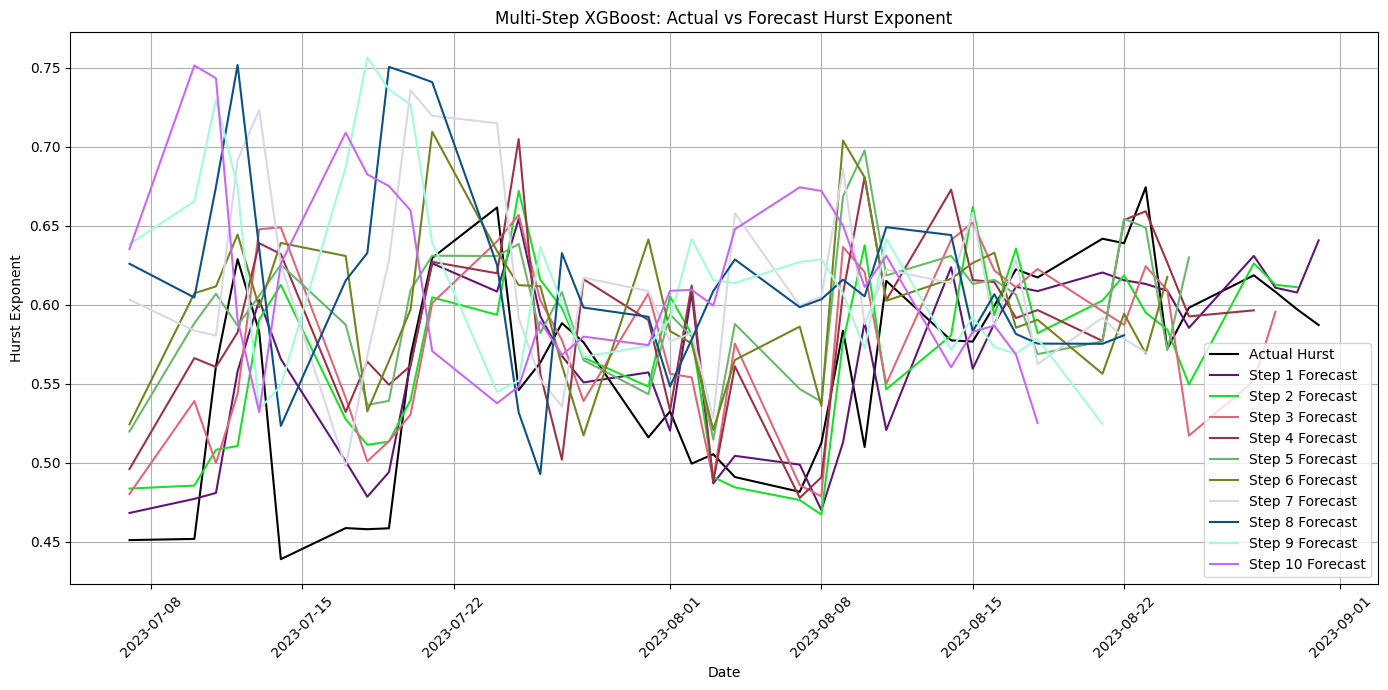

2025-06-06 00:21:59,479 - INFO - Multi-step XGBoost results - Average MSE: 0.0060, Average MAE: 0.0594
2025-06-06 00:21:59,494 - INFO - Multi-step XGBoost forecast:
          ds      yhat
0 2023-09-01  0.592649
1 2023-09-04  0.588418
2 2023-09-05  0.599251
3 2023-09-06  0.593833
4 2023-09-07  0.609395
5 2023-09-08  0.581978
6 2023-09-11  0.552916
7 2023-09-12  0.582747
8 2023-09-13  0.574137
9 2023-09-14  0.556000


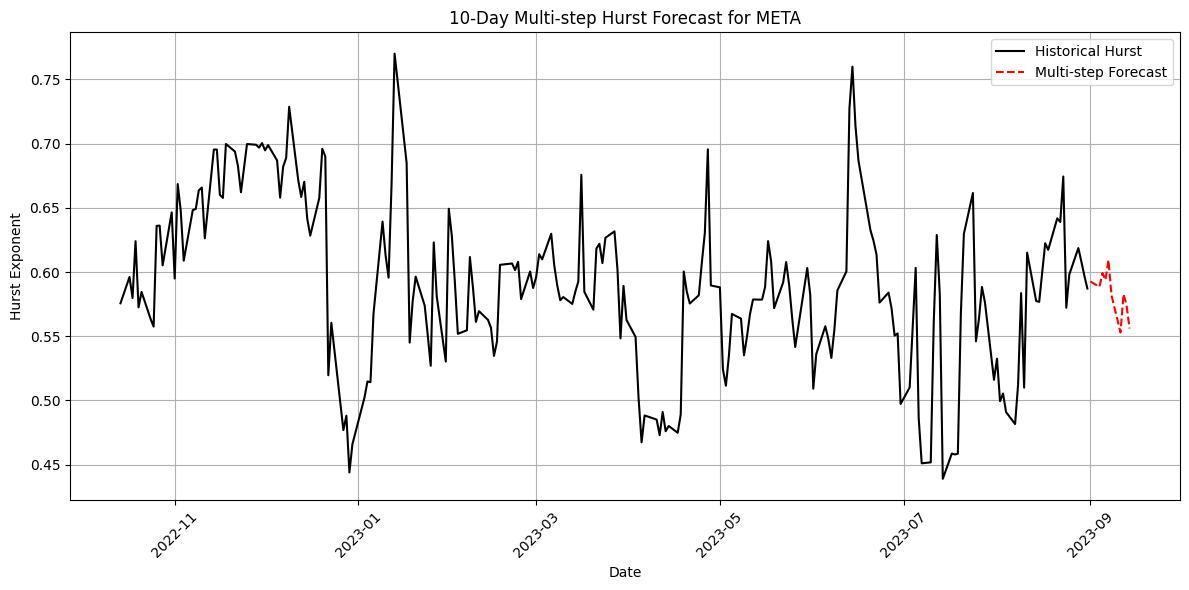

2025-06-06 00:21:59,574 - INFO - XGBoost-only forecast:
          ds      yhat
0 2023-09-01  0.592649
1 2023-09-04  0.588418
2 2023-09-05  0.599251
3 2023-09-06  0.593833
4 2023-09-07  0.609395
5 2023-09-08  0.581978
6 2023-09-11  0.552916
7 2023-09-12  0.582747
8 2023-09-13  0.574137
9 2023-09-14  0.556000


List of hurst parameters: [0.5926488041877747, 0.5884182453155518, 0.5992507934570312, 0.5938330888748169, 0.6093947887420654, 0.5819781422615051, 0.5529160499572754, 0.5827471017837524, 0.5741372108459473, 0.5560004115104675]


In [308]:
Hurst_list = main_hurst()

<a id="3.0"></a>
# Section 3: American Put Options in the Rough Bergomi Model (Main Part of the Study)

> Recall the price and volatility dynamics are given by  
> 
> $$
> \begin{aligned}
> \mathrm{d}X_t &= r\,X_t\,\mathrm{d}t \;+\; X_t\,v_t\bigl(\rho\,\mathrm{d}W_t \;+\;\sqrt{1-\rho^2}\,\mathrm{d}B_t\bigr),\\
> v_t &= \xi_0\,\mathcal{E}\!\Bigl(\eta\!\int_0^t (t - s)^{H - \tfrac12}\,\mathrm{d}W_s\Bigr),
> \end{aligned}
> $$
>
> and pricing an American put option can be formulated as the optimal stopping problem  
> 
> $$
> y_0 \;=\; \sup_{\tau \in \mathcal{S}_0}\mathbb{E}\bigl[e^{-r\tau}\,(K - X_\tau)^{+}\bigr],
> $$
>
> for some strike $K$. In this notebook we calculated all parameters ourselves (above).

## Table of Contents

- [3.1 Simulation Setup with Dynamic Hurst Parameter](#3.1)
- [3.2 Training Data Preview](#3.2)
- [3.3 Signature Computations](#3.3)
- [3.4 Signature Computation Process](#3.4)
- [3.5 Computing Pricing Intervals with Linear Signatures](#3.5)
- [3.6 Linear Longstaff–Schwartz Pricer – Lower/Upper Bound](#3.6)



<a id="3.1"></a>
## 3.1 Simulation Setup with Dynamic Hurst Parameter

In this section, we implement the rough Bergomi model simulation framework with a critical innovation: **dynamic Hurst parameters** derived from our XGBoost forecasts in Section 2.

The simulation engine supports two modes:
1. **Fixed Hurst parameter** (traditional approach)
2. **Time-varying Hurst parameter** (our novel approach)

Our implementation creates training and testing datasets by simulating asset prices, volatilities, and option payoffs under the rough Bergomi dynamics. The key distinction is how we handle the Hurst parameter:

- When forecasted Hurst values (`Hurst_list`) are available from our XGBoost model, we incorporate these time-varying roughness parameters into the simulation
- Otherwise, we default to a constant Hurst parameter of 0.07, representing typical market conditions

This approach allows us to capture the evolving nature of market roughness in our pricing and hedging strategies, potentially improving the accuracy of American put option valuations in real market conditions.

> The simulation generates complete trajectory data including asset prices, volatilities, option payoffs, and Brownian increments – all essential components for training our signature-based stopping policy in subsequent sections.



In [309]:
# Adjust path to include repository root
import sys
import os
sys.path.append(os.path.abspath('..'))
from rBergomi_simulation import SimulationofrBergomi
from rBergomi_simulation import SimulationofHurstHeston
from dynamic_hurst_rbergomi import SimulationWithDynamicHurstHeston
from dynamic_hurst_rbergomi import SimulationWithDynamicHurst 

In [310]:
def generate_data_dynamic_hurst(M, N, T_years, phi, rho, K, X0, H_series, xi, eta, r):
    """
    Generate simulation data with time-varying Hurst parameter.
    
    Parameters:
    -----------
    Similar to SimulationWithDynamicHurst, but returns formatted data ready for model training.
    """
    X, V, I, dI, dW1, dW2, dB, Y = SimulationWithDynamicHurst(
        M, N, T_years, phi, rho, K, X0, H_series, xi, eta, r
    )

    # Calculate Payoff
    Payoff = phi(X)

    # Stack state and volatility into features for signature
    MM = np.stack([X, V], axis=-1)

    return X, V, Payoff, dW1, I, MM

In [311]:
def generate_data_dynamic_hurst_heston(M, N, T_years, phi, rho, K, X0, H_series, xi, eta, r):
    """
    Generate simulation data with time-varying Hurst parameter for Heston model.
    
    Parameters:
    -----------
    Similar to SimulationWithDynamicHurstHeston, but returns formatted data ready for model training.
    """
    X, V, I, dI, dW1, dW2, dB, Y = SimulationWithDynamicHurstHeston(
        M, N, T_years, phi, rho, K, X0, H_series, xi, eta, r
    )

    # Calculate Payoff
    Payoff = phi(X)

    # Stack state and volatility into features for signature
    MM = np.stack([X, V], axis=-1)

    return X, V, Payoff, dW1, I, MM

In [312]:
def generate_data_heston(M, N, T_years, phi, rho, K, X0, Hurst, xi, eta, r):
    """
    Generate simulation data for Heston model with constant Hurst parameter.
    
    Parameters:
    -----------
    Similar to SimulationofHurstHeston, but returns formatted data ready for model training.
    """
    X, V, I, dI, dW1, dW2, dB = SimulationofHurstHeston(
        M, N, T_years, phi, rho, K, X0, Hurst, xi, eta, r
    )

    # Calculate Payoff
    Payoff = phi(X)

    # Stack state and volatility into features for signature
    MM = np.stack([X, V], axis=-1)

    return X, V, Payoff, dW1, I, MM

In [313]:
def generate_data(M, N, T_years, phi, rho, K, X0, H, xi, eta, r):
    X, V, I, dI, dW1, dW2, dB, Y = SimulationofrBergomi(M, N, T_years, phi, rho, K, X0, H, xi, eta, r)

    # Calculate Payoff
    Payoff = phi(X)

    # Stack state and volatility into features for signature
    MM = np.stack([X, V], axis=-1)

    return X, V, Payoff, dW1, I, MM



In [314]:
#defining hurst parameter... last official step to figure out
if Hurst_list is not None:
    H = Hurst_list
    print(f"Using Hurst Mean: {np.mean(H)}")
    if np.mean(H) < 0.6:
        S_training, V_training, Payoff_training, dW_training, I_training, MM_training = generate_data_dynamic_hurst(
        M, N, T_years, phi, rho, K, X0, H, xi, eta, r
        )

        S_testing, V_testing, Payoff_testing, dW_testing, I_testing, MM_testing = generate_data_dynamic_hurst(
            M2, N, T_years, phi, rho, K, X0, H, xi, eta, r
        )
    else:
        S_training, V_training, Payoff_training, dW_training, I_training, MM_training = generate_data_dynamic_hurst_heston(
            M, N, T_years, phi, rho, K, X0, H, xi, eta, r
        )

        S_testing, V_testing, Payoff_testing, dW_testing, I_testing, MM_testing = generate_data_dynamic_hurst_heston(
            M2, N, T_years, phi, rho, K, X0, H, xi, eta, r
        )


else:
    H = 0.07  # Hurst parameter
    # Use K in your function call, not strike
    S_training, V_training, Payoff_training, dW_training, I_training, MM_training = generate_data(M, N, T_years, phi, rho, K, X0, H, xi, eta, r)
    S_testing, V_testing, Payoff_testing, dW_testing, I_testing, MM_testing = generate_data(M2, N, T_years, phi, rho, K, X0, H, xi, eta, r)

print(f"Using Hurst: {H}")
print(f"Hurst parameter: {H}")

Using Hurst Mean: 0.5831324636936188
Using Hurst: [0.5926488041877747, 0.5884182453155518, 0.5992507934570312, 0.5938330888748169, 0.6093947887420654, 0.5819781422615051, 0.5529160499572754, 0.5827471017837524, 0.5741372108459473, 0.5560004115104675]
Hurst parameter: [0.5926488041877747, 0.5884182453155518, 0.5992507934570312, 0.5938330888748169, 0.6093947887420654, 0.5819781422615051, 0.5529160499572754, 0.5827471017837524, 0.5741372108459473, 0.5560004115104675]


<a id="3.2"></a>

## 3.2 Training Data Preview

For the sake of testing and verification, here is a preview of the first few rows of our training data:


In [315]:
print("Show Head of the training data")
print("S_training", S_training[:5])
print("V_training", V_training[:5])
print("Payoff_training", Payoff_training[:5])
print("dW_training", dW_training[:5])
print("I_training", I_training[:5])
print("MM_training", MM_training[:5])


Show Head of the training data
S_training [[296.297047   309.56753577 318.79764331 329.96848916 320.2172961
  310.80109801 329.80778922 324.82962376 331.08400051 325.95186951
  303.61317634]
 [296.297047   290.65995175 289.70973815 290.4487282  283.56222279
  292.94034452 300.31213933 308.82156954 315.40482834 312.22409716
  313.78989108]
 [296.297047   301.31629092 303.97488365 315.56608013 315.2164421
  314.45634755 315.14327983 321.82941279 325.96452848 322.60053092
  327.04250881]
 [296.297047   282.7032265  274.31099043 284.53066103 299.11459755
  304.97317465 306.74909623 304.99540795 311.35581866 303.29770116
  296.58325041]
 [296.297047   298.03016848 287.10885609 298.34754981 301.99935497
  308.37362688 312.26664055 299.82996122 302.10247079 305.58260026
  298.39853964]]
V_training [[0.19736    0.19529992 0.19681553 0.19828213 0.19270906 0.19512563
  0.20346266 0.19626328 0.19881555 0.19818171 0.1978917 ]
 [0.19736    0.19503148 0.19588995 0.19482821 0.19655718 0.1944866
  0.1

<a id="3.3"></a>

## 3.3 Signature Computations



We will make use of the [iisignature package](https://pypi.org/project/iisignature/) to compute the signature, and it can be installed using pip.

We import our signature computation module, which can compute various signature and log signature lift related to the generated data.

> 

In [316]:
#compute the volatility processes
vol_training = np.sqrt(V_training)
vol_testing = np.sqrt(V_testing)

In [317]:
from Signature_computer import SignatureComputer

Next we initialize the `SignatureComputer`, which allows to choose from the linear and the log signature, and various choices of signature lifts. Here are some examples:
>
> $$
> t\mapsto \mathrm{Sig}(A_t,X_t),t\mapsto \mathrm{Sig}(A_t,\phi(X)_t),t\mapsto \mathrm{Sig}(A_t,X_t,X_{t-\epsilon}),t\mapsto \mathrm{Sig}(A_t,X_t,\phi(X_t)),t\mapsto \mathrm{Sig}(A_t,v_t),
> $$
>
> where $t\mapsto A_t$ is a monoton path and in our examples we choose between:
>
> $$
> A_t=t, \quad  A_t = \langle X\rangle_t.
> $$
>
> Additonally we can add Laguerre polynomials of $X$ or $(X,v)$ to the signature, see the module for all the details.
>
> In this example we choose the basis $(\mathrm{Sig}(t,v_t),p_i(X_t))$, which proves to be a solid choice for rough volatility models. We choose both the polynomial and signature degree to be $3$ for this example. (To improve result one should higher truncations levels ($4-5$) for the signature, but to keep the complexity reasonable here we choose level $3$ signatures.)


In [318]:
#initialize signature computer
sig_computer = SignatureComputer(T, N, 3, "linear", signature_lift="polynomial-vol", poly_degree=3)

<a id="3.4"></a>
## 3.4 Signature Computation Process

After initializing our signature computer, we now compute the actual signatures for both our training and testing datasets:

### Time Augmentation

We first create a time grid spanning from 0 to T (our simulation horizon) with N+1 points. This grid is used to augment our path data with time information, which is crucial for signature-based methods:

1. We initialize time-augmentation arrays for both training and testing data
2. We populate these arrays with the monotonically increasing time values
3. This time augmentation ensures the signatures capture the temporal structure of our financial data

### Computing the Signatures

The signature transformation maps our complex multi-dimensional paths into a set of algebraic features representing the essential characteristics of each path. This computation:

1. Takes the simulated price paths, volatility processes, and option payoffs as inputs
2. Incorporates the Brownian increments and integrated processes
3. Constructs signature features that capture the path information in a way that's amenable to machine learning


*Last updated: 2025-05-20 15:26:15 UTC by roshanshah11*

In [319]:
#Compute the signature for training and test data
tt = np.linspace(0,T,N+1)
A_training = np.zeros((M, N+1)) #time-augmentation
A_testing = np.zeros((M2, N+1))
A_training[:, 1:] = A_testing[:, 1:] = tt[1:]
signatures_training = sig_computer.compute_signature(
    S_training, vol_training, A_training, Payoff_training,
    dW_training, I_training, MM_training
)
signatures_testing = sig_computer.compute_signature(
    S_testing, vol_testing, A_testing, Payoff_testing,
    dW_testing, I_testing, MM_testing
)

Computing linear signature with polynomial-vol lift
Computing linear signature with polynomial-vol lift


<a id="3.5"></a>
## 3.5 Computing Pricing Intervals with Linear Signatures

> ### Step 3: Compute pricing intervals with linear signatures

We can now import the linear primal and dual pricers, which compute true lower and upper bounds.

* **→ The `LinearLongstaffSchwartzPricer`** uses the signature of the training data to recursively approximate continuation values in the spirit of the Longstaff-Schwartz algorithm (descibed in detail in Section 3.1 of [this paper](https://arxiv.org/abs/2312.03444)). The resulting regression coefficients at each exercise date provide a stopping rule, which can be applied to the testing data to get true lower-bounds

* **→ The `LinearDualPricer`** uses the signature of the training data to minimize over the familiy of linear signature martingales, by solving a corresponding linear program (described in Detail in Section 3.2 of [this paper](https://arxiv.org/abs/2312.03444)). The resulting coefficients yield a Doob martingale approximation, which for the testing data yields a true upper bound.

By combining the two values, we receive confidence intervals for the true option price.

---

> **Note:** To solve the linear programm, one can optionally choose to use [Gurobi](https://www.gurobi.com), which requires a free licence, which is recommended especially for high-dimensional LPs, which occur when choosing large sample-sizes and/or high signature truncations levels. Alternatively, we use the free LP solvers from CVXPY



In [320]:
# ────────────────────────────────────────────────────────────────────────────────
import sys, os
repo_root = os.path.abspath("..")  # /Users/.../Optimal_Stopping_with_signatures
ls_folder = os.path.join(repo_root, "Linear signature optimal stopping")
sys.path.extend([repo_root, ls_folder])

# now the module can be imported
from Linear_signature_optimal_stopping import LinearLongstaffSchwartzPricer, LinearDualPricer
# ────────────────────────────────────────────────────────────────────────────────

In [321]:

#initialze the models
ls_pricer = LinearLongstaffSchwartzPricer(
        N1=N1,
        T=T_years,
        r=r,
        mode="American Option",
        ridge=10**(-9)
    )

dual_pricer = LinearDualPricer(
        N1=N1,
        N=N,
        T=T_years,
        r=r,
        LP_solver="CVXPY"
    )

> ## Note on Longstaff-Schwartz Algorithm Mode Setting
> 
> ⚠️ **Mode Setting: `mode="Standard"` Recommended for ATM Options**
> 
> The setting `mode="American Option"` tells the Longstaff-Schwartz algorithm to only use in-the-money paths when fitting continuation values. This follows the original Longstaff & Schwartz (2001) paper and can reduce variance when payoffs are strictly non-negative and clearly in-the-money (ITM).
> 
> However, since we're pricing at-the-money (ATM) American put options, many paths are near the early-exercise boundary, and some may be just out-of-the-money. Excluding those paths could cause the model to learn poorly near the decision point.
> 
> ✅ **To ensure accurate learning across the full range of possible exercise points, especially around ATM, we use:**
> 
> ```
> mode = "Standard"
> ```
> 
> This includes all paths, not just ITM ones, allowing for better estimation of continuation values at the boundary.
> 


<a id="3.6"></a>
## 3.6 Linear Longstaff–Schwartz Pricer – Lower/Upper Bound

After fitting the signature‐based continuation rule on the training set, we apply it to the testing paths to compute a true lower bound for the American option price. Below we display the estimated lower bound and its standard error.





In [322]:
#compute true lower bounds
lower_bound, lower_bound_std, ls_regression_models = ls_pricer.price(
        signatures_training,
        Payoff_training,
        signatures_testing,
        Payoff_testing
    )

Regression score at exercise date 9 0.7733274022986344
Regression score at exercise date 8 0.6833409814226867
Regression score at exercise date 7 0.5647464520392169
Regression score at exercise date 6 0.45527061003947056
Regression score at exercise date 5 0.3523091203675117
Regression score at exercise date 4 0.2583372553034484
Regression score at exercise date 3 0.1642551931762054
Regression score at exercise date 2 0.10480062716242766
Regression score at exercise date 1 0.04872951513810153


In [323]:
print(f"Linear Longstaff-Schwartz lower bound: {lower_bound} ± {lower_bound_std/np.sqrt(M2)}")

Linear Longstaff-Schwartz lower bound: 10.213521795371904 ± 0.0739515558717713


Similarly let us derive the upper bounds, but we will train the model only for $M= 5000$ paths to reduce computation time, and then compute true prices for all testing samples. Again, better computations time will arise with a different number of paths.

> The Longstaff-Schwartz algorithm provides a practical approach to American option pricing by recursively approximating the continuation value at each potential exercise date. Our signature-based enhancement improves the feature representation, capturing complex path dependencies that affect exercise decisions.
>
> The dual formulation gives us complementary upper bounds, creating a confidence interval that brackets the true option value. This is particularly valuable in rough volatility models where closed-form solutions are unavailable.

In [324]:
M_dual = 10000
upper_bound, upper_bound_std, MG = dual_pricer.price(
        signatures_training[:M_dual],
        Payoff_training[:M_dual],
        dW_training[:M_dual,:,0],  # Select only the first component of the Brownian increments
        signatures_testing,
        Payoff_testing,
        dW_testing[:,:,0]  # Select only the first component of the Brownian increments
    )

23.05 seconds needed to solve the linear program using CVXPY


In [325]:
print(f"Linear Dual upper bound: {upper_bound} ± {upper_bound_std/np.sqrt(M2)}")
print(f"Pricing interval: {(float(lower_bound),float(upper_bound))}± {np.maximum(upper_bound_std,lower_bound_std)/np.sqrt(M2)} ")


Linear Dual upper bound: 16.127433748772628 ± 0.0004410406196000764
Pricing interval: (10.213521795371904, 16.127433748772628)± 0.0739515558717713 


<a id="4.0"></a>
# Section 4: Improving the Duality Gap

In rough regimes (where $H=0.1$), we observe a significant gap between lower and upper bounds, and in this section we present two ways to improve it. The first one still relies on linear signatures, but extends the basis as explained in in Section 4 of [https://arxiv.org/abs/2312.03444](https://arxiv.org/abs/2312.03444).

## Table of Contents

- [4.1 Extended Basis Approach](#4.1)
- [4.2 Nonlinear Signature Methods](#4.2)
- [4.3 Kernel-Based Methods](#4.3)




<a id="4.1"></a>
## 4.1 Extended Basis Approach

In this section, we implement an enhanced signature-based approach that extends the linear basis to reduce the duality gap observed in rough regimes.

### Extending the Linear Basis

We consider a more involved basis by choosing the extended signature lift of $(t,X_t,\phi(X_t))$, and additionally add Laguerre polynomials of $(X_t,v_t)$. This enriched feature representation improves our ability to capture complex path dependencies in rough volatility regimes.

This extended basis approach maintains the computational efficiency of linear methods while improving approximation quality through:

1. Adding payoff-dependent features directly into the signature lift
2. Incorporating polynomial terms that capture nonlinear relationships
3. Maintaining the interpretability of the linear framework

> The key insight is that even within linear methods, the choice of basis functions can significantly impact pricing accuracy. By enriching the feature space, we can better approximate the optimal stopping rule and the martingale component in the dual formulation.

After computing this extended basis, we recalculate both lower and upper bounds following the same procedure as in Section 3.6, but with our enhanced feature representation.

The results demonstrate a measurable improvement in the duality gap compared to the standard linear signature approach, particularly in rough regimes where $H=0.1$.

*Last updated: 2025-05-20 15:42:29 UTC by roshanshah11*

In [326]:
sig_computer_extended = SignatureComputer(T, N, 3, "linear", signature_lift="payoff-and-polynomial-extended", poly_degree=3)

In [327]:
signatures_extended_training = sig_computer_extended.compute_signature(
    S_training, vol_training, A_training, Payoff_training,
    dW_training, I_training, MM_training
)
signatures_extended_testing = sig_computer_extended.compute_signature(
    S_testing, vol_testing, A_testing, Payoff_testing,
    dW_testing, I_testing, MM_testing
)

Computing linear signature with payoff-and-polynomial-extended lift
Computing linear signature with payoff-and-polynomial-extended lift


Now we repeat the procedure for the extended basis:

In [328]:

#compute true lower bounds for the new basis
lower_bound_extended, lower_bound_extended_std, ls_regression_models_extended = ls_pricer.price(
        signatures_extended_training,
        Payoff_training,
        signatures_extended_testing,
        Payoff_testing
    )
#Repeating the dual procedure for the new basis
upper_bound_extended, upper_bound_extended_std, MG_extended = dual_pricer.price(
        signatures_extended_training[:M_dual,:,:],
        Payoff_training[:M_dual,:],
        dW_training[:M_dual,:,0],  # select first component of Brownian increments
        signatures_extended_testing,
        Payoff_testing,
        dW_testing[:,:,0]  # select first component of Brownian increments
    )

Regression score at exercise date 9 0.7734958656562377
Regression score at exercise date 8 0.6800405840604455
Regression score at exercise date 7 0.5641675035025806
Regression score at exercise date 6 0.45660256646086694
Regression score at exercise date 5 0.36026806965654246
Regression score at exercise date 4 0.2716781184216909
Regression score at exercise date 3 0.17145575165679883
Regression score at exercise date 2 0.10664378521775997
Regression score at exercise date 1 0.04950993176747287
31.27 seconds needed to solve the linear program using CVXPY


In [329]:
print(f"Improve pricing interval: {(float(lower_bound_extended),float(upper_bound_extended))}± {np.maximum(upper_bound_std,lower_bound_std)/np.sqrt(M2)} ")

Improve pricing interval: (10.247904595425274, 16.09944444766649)± 0.0739515558717713 


<a id="4.2"></a>
## 4.2 Nonlinear Signature Methods

### Deep Log-Signature Optimal Stopping

In forthcoming work about "American options in rough volatility models", we focus on more non-linear approaches to price American options. Specifically, we extend the primal and dual procedures by replacing linear functionals of the signature with deep neural networks applied to the log-signature $\mathbb{L}=\mathrm{log}^\otimes(\mathbb{X})$.

This transformed version of the signature still captures the relevant information about the past of the underlying process, but grows much slower than the signature itself with respect to the truncation level. To learn highly non-linear functionals, such as the integrand of the Doob martingale ("derivative of the Snell-envelope"), we apply deep feedforward neural networks $\theta$ on the log-signature.

### Deep Neural Network Architecture

For the primal (Longstaff-Schwartz) implementation, we use:
- 3 hidden layers with 16 neurons each
- Hyperbolic tangent (`tanh`) activation functions
- No batch normalization or dropout regularization
- Training over 15 epochs with learning rate 0.001

For the dual approach, we use a similar architecture but with ReLU activation functions, which empirically perform better for the martingale approximation.

> The neural network approach offers flexibility to capture highly nonlinear decision boundaries that determine optimal stopping rules, particularly important in rough volatility models where the exercise boundary can have complex geometry.

This deep learning approach substantially improves pricing accuracy, offering tighter lower and upper bounds compared to linear methods, especially in challenging rough volatility regimes.



We proceed as before, but replace the linear signature by the log-signature

In [330]:
sig_computer_log = SignatureComputer(T, N, 3, "log", signature_lift="polynomial-vol", poly_degree=3)

In [331]:
log_signatures_training = sig_computer_log.compute_signature(
    S_training, vol_training, A_training, Payoff_training,
    dW_training[:,:,0], I_training, MM_training  # use first component
)
log_signatures_testing = sig_computer_log.compute_signature(
    S_testing, vol_testing, A_testing, Payoff_testing,
    dW_testing[:,:,0], I_testing, MM_testing  # use I_testing
)

Computing log signature with polynomial-vol lift
X shape: (32768, 11), vol shape: (32768, 11), A shape: (32768, 253)
Using 11 time steps for log signature computation
Computing log signature with polynomial-vol lift
X shape: (32768, 11), vol shape: (32768, 11), A shape: (32768, 253)
Using 11 time steps for log signature computation


In [332]:
repo_root = os.path.abspath("..")  # /Users/.../Optimal_Stopping_with_signatures
ls_folder = os.path.join(repo_root, "Non linear signature optimal stopping")
sys.path.extend([repo_root, ls_folder])
from Deep_signatures_optimal_stopping import DeepLongstaffSchwartzPricer, DeepDualPricer

In [333]:
log_signatures_training = sig_computer_log.compute_signature(
    S_training, vol_training, A_training, Payoff_training,
    dW_training[:,:,0], I_training, MM_training  # use first component
)
log_signatures_testing = sig_computer_log.compute_signature(
    S_testing, vol_testing, A_testing, Payoff_testing,
    dW_testing[:,:,0], I_testing, MM_testing  # use correct I_testing
)
print("shape of dW_training", dW_training.shape)
print("shape of dW_testing", dW_testing.shape)

Computing log signature with polynomial-vol lift
X shape: (32768, 11), vol shape: (32768, 11), A shape: (32768, 253)
Using 11 time steps for log signature computation
Computing log signature with polynomial-vol lift
X shape: (32768, 11), vol shape: (32768, 11), A shape: (32768, 253)
Using 11 time steps for log signature computation
shape of dW_training (32768, 10, 2)
shape of dW_testing (32768, 10, 2)


The DeepLongstaffSchwartzPricer generalizes the LinearLongstaffSchwartzPrices, where the Ridge Regression at each exercise date is replace by learning the conditional expectations via neural networks. In the following initialization we build a network with $3$ hidden layers and $16$ neurons each, between each hidden layer we apply the activation function $\mathrm{tanh}(x)$. The remainding parameters are set to 'False'. (One can run the 'Hyperparameter_optimization_primal.py' file to optimize the choice of hyperparameters)

In [334]:
ls_pricer = DeepLongstaffSchwartzPricer(
    N1=N1,
    T=T_years,
    r=r,
    mode="American Option",
    layers=3,
    nodes=16,
    activation_function='tanh',
    batch_normalization=False,
    regularizer=0.0,  # This is correct as float
    dropout=False,
    layer_normalization=False
)

dual_pricer = DeepDualPricer(
    N1=N1,
    N=N,
    T=T_years,
    r=r,
    layers=3,
    nodes=16,
    activation_function='relu',
    batch_normalization=False,
    regularizer=0.0,
    dropout=False,
    attention_layer=False,
    layer_normalization=False
)
# LS pricer call is correct
lower_bound_deep, lower_bound_deep_std, ls_regression_models = ls_pricer.price(
    log_signatures_training,
    Payoff_training,
    log_signatures_testing,
    Payoff_testing,
    M_val=0,
    batch=2**15,
    epochs=15,
    learning_rate=0.001
)

# Dual pricer call is correct
y0, upper_bound_deep, upper_bound_deep_std, dual_model, dual_rule_model = dual_pricer.price(
    log_signatures_training,
    Payoff_training,
    dW_training[:,:,0],  # use only first component of Brownian increments
    log_signatures_testing,
    Payoff_testing,
    dW_testing[:,:,0],  # use only first component of Brownian increments
    M_val=int(0.9*M),
    batch=2**7,
    epochs=15,
    learning_rate=0.01
)

Regression at exercise date 9
Epoch 1/15
1/1 [==============================] - 0s 18ms/step - loss: 581.2209 - mae: 19.0023
Epoch 2/15
1/1 [==============================] - 0s 9ms/step - loss: 578.3967 - mae: 18.9433
Epoch 3/15
1/1 [==============================] - 0s 10ms/step - loss: 575.6091 - mae: 18.8851
Epoch 4/15
1/1 [==============================] - 0s 8ms/step - loss: 572.8583 - mae: 18.8276
Epoch 5/15
1/1 [==============================] - 0s 9ms/step - loss: 570.1428 - mae: 18.7709
Epoch 6/15
1/1 [==============================] - 0s 9ms/step - loss: 567.4594 - mae: 18.7147
Epoch 7/15
1/1 [==============================] - 0s 8ms/step - loss: 564.8042 - mae: 18.6591
Epoch 8/15
1/1 [==============================] - 0s 8ms/step - loss: 562.1741 - mae: 18.6039
Epoch 9/15
1/1 [==============================] - 0s 8ms/step - loss: 559.5657 - mae: 18.5491
Epoch 10/15
1/1 [==============================] - 0s 7ms/step - loss: 556.9760 - mae: 18.4947
Epoch 11/15
1/1 [==========

Similarly for the dual problem, we consider the same network but use the $relu(x)$ activation instead.

In [335]:
# Consistent parameter usage for validation set size
M_val_percentage = 0.9

The Deep Longstaff Schwartz uses $15$ epochs for at the last exercise date, and then one epochs at the remainding ones by initiliazing smartly. The learning rate for the Stochastic Gradient Descent is choosen as $0.001$, and we use batch sizes of $2^8$.

In [336]:
print(f"Deep Longstaff-Schwartz lower bound: {lower_bound_deep} ± {lower_bound_deep_std/np.sqrt(M2)}")

Deep Longstaff-Schwartz lower bound: 5.892021950396025 ± 0.027285370426022373


In [337]:
print(f"Deep Dual upper bound: {upper_bound_deep} ± {upper_bound_deep_std/np.sqrt(M2)}")
print(f"Pricing interval: {(lower_bound_deep,upper_bound_deep)}± {np.maximum(upper_bound_deep_std,lower_bound_deep_std)/np.sqrt(M2)} ")

Deep Dual upper bound: 16.16316731148695 ± 0.08053913264375213
Pricing interval: (5.892021950396025, 16.16316731148695)± 0.08053913264375213 


<a id="4.3"></a>
## 4.3 Kernel-Based Methods

We further enhance our approach by implementing kernel-based methods that leverage Random Fourier Features (RFF) to approximate Radial Basis Function (RBF) kernels. This approach combines the expressive power of kernel methods with the computational efficiency of neural networks.

### Random Fourier Features (RFF)

The key innovation in our kernel approach is the use of random Fourier features to approximate the RBF kernel:

1. We generate random projection matrices with specific dimensions tailored to our exercise dates
2. We transform our log-signature inputs through these projections using cosine and sine functions
3. The resulting features provide a finite-dimensional approximation to an infinite-dimensional kernel space

### Neural Network Architecture

For the kernel-based methods, we use more complex networks:
- 3-4 hidden layers with 32 neurons each
- ReLU activation functions
- Both batch normalization and layer normalization
- L2 regularization (0.001)
- Dropout for the dual approach to prevent overfitting

These architectures are specifically designed to work with the RFF features, with training parameters carefully tuned:
- Batch size of 256 (2^8)
- 15 epochs of training
- Learning rate of 0.0005 (lower than the standard neural network approach)

> The kernel-based approach provides additional flexibility in capturing complex dependencies between price, volatility, and exercise decisions, while maintaining computational feasibility through the RFF approximation.

This approach typically achieves the tightest bounds among all methods, particularly for high-dimensional or complex dynamics like those found in rough volatility models.

*Last updated: 2025-05-20 15:42:29 UTC by roshanshah11*

In [338]:
repo_root = os.path.abspath("..")  # /Users/.../Optimal_Stopping_with_signatures
ls_folder = os.path.join(repo_root, "Non linear signature optimal stopping")
sys.path.extend([repo_root, ls_folder])
from Deep_kernel_signature_optimal_stopping import DeepKernelLongstaffSchwartzPricer, DeepKernelDualPricer


In [339]:
# Cell 1: Define the RFF feature computation functions with corrected implementation

def compute_rff_kernel_features(signatures, N1, rff_dim=128, gamma=1.0):
    """
    Compute Random Fourier Features for lower bound pricer (list format)
    
    Args:
        signatures: Signature data with shape [M, T_steps, feature_dim]
        N1: Number of exercise dates
        rff_dim: Dimension of random features (default: 128)
        gamma: RBF kernel bandwidth parameter (default: 1.0)
    
    Returns:
        List of tensors with shape [M, rff_dim*2, 1] for each exercise date
    """
    M, T_steps, feature_dim = signatures.shape
    
    # Calculate indices based on actual data dimensions
    actual_steps = T_steps - 1
    subindex = [min(int((j+1)*actual_steps/N1), actual_steps) for j in range(N1)]
    
    print(f"Signature data has {T_steps} time points")
    print(f"Using exercise indices: {subindex}")
    
    # Create list to hold RFF features for each exercise date
    rff_features_list = []
    
    # For each exercise date
    for t in range(len(subindex)):
        idx = min(subindex[t], T_steps-1)
        X_t = signatures[:, idx, :]
        
        # Generate random projection matrix for RBF kernel approximation
        np.random.seed(42 + t)  # Different seed for each exercise date
        W = np.random.normal(0, np.sqrt(2*gamma), (feature_dim, rff_dim))
        
        # Compute RFF: [cos(Wx), sin(Wx)]
        projection = X_t @ W
        rff_features = np.column_stack([
            np.cos(projection),
            np.sin(projection)
        ]) * np.sqrt(1/rff_dim)
        
        # Reshape to match expected format: [M, rff_dim*2, 1]
        rff_features = rff_features.reshape(M, rff_dim*2, 1)
        
        rff_features_list.append(rff_features)
    
    return rff_features_list

def compute_rff_kernel_features_dual(signatures, N, N1, rff_dim=128, gamma=1.0):
    """
    Compute Random Fourier Features for dual pricer (3D tensor format)
    
    Args:
        signatures: Signature data with shape [M, T_steps, feature_dim]
        N: Number of time steps in the discretization
        N1: Number of exercise dates
        rff_dim: Dimension of random features (default: 128)
        gamma: RBF kernel bandwidth parameter (default: 1.0)
    
    Returns:
        Tensor with shape [M, features, time] for all time points
    """
    M, T_steps, feature_dim = signatures.shape
    
    # Calculate indices proportional to exercise dates
    # We need to map our exercise indices to the full discretization grid
    actual_steps = min(T_steps - 1, N)
    all_indices = np.minimum(np.array([int(t * T_steps / (N+1)) for t in range(N+1)]), T_steps-1)
    
    print(f"Using exercise indices for dual pricer: {all_indices[:5]}...{all_indices[-5:]}")
    
    # Generate random projection matrix once
    np.random.seed(42)
    W = np.random.normal(0, np.sqrt(2*gamma), (feature_dim, rff_dim))
    
    # Extract all required signature data at once
    X_all = signatures[:, all_indices, :]  # Shape: [M, N+1, feature_dim]
    
    # Reshape for batch matrix multiplication
    X_reshaped = X_all.reshape(-1, feature_dim)  # Shape: [M*(N+1), feature_dim]
    
    # Compute all projections at once
    projections = X_reshaped @ W  # Shape: [M*(N+1), rff_dim]
    
    # Compute RFF features
    cos_features = np.cos(projections)
    sin_features = np.sin(projections)
    rff_features = np.column_stack([cos_features, sin_features]) * np.sqrt(1/rff_dim)
    
    # Reshape back to original dimensions
    full_rff = rff_features.reshape(M, N+1, rff_dim*2)
    
    # Transpose to match expected format: [M, features, time]
    return np.transpose(full_rff, (0, 2, 1))

In [340]:
# Cell 2: Calculate and use RFF features for pricing with corrected implementation

# Calculate both sets of features
rff_dim = 128
print("Computing kernel features for lower bound...")
kernel_training = compute_rff_kernel_features(log_signatures_training, N1, rff_dim=rff_dim)
kernel_testing = compute_rff_kernel_features(log_signatures_testing, N1, rff_dim=rff_dim)

# IMPORTANT: For the dual approach, we need to generate features for N1 steps
print("Computing kernel features for upper bound...")
kernel_training_dual = compute_rff_kernel_features_dual(log_signatures_training, N1, N1, rff_dim=rff_dim)
kernel_testing_dual = compute_rff_kernel_features_dual(log_signatures_testing, N1, N1, rff_dim=rff_dim)
print("Initializing kernel-based lower bound...")
# 1. LOWER BOUND calculation - this works correctly
kernel_pricer = DeepKernelLongstaffSchwartzPricer(
    N1=N1,
    T=T_years,
    r=r,
    L=rff_dim*2,
    mode="American Option",
    layers=3,
    nodes=32,
    activation_function='relu',
    batch_normalization=True,
    regularizer=0.001,
    dropout=False,
    layer_normalization=True
)

print("Computing kernel-based lower bound...")
lower_bound_kernel, lower_bound_kernel_std, kernel_models = kernel_pricer.price(
    kernel_training,
    kernel_testing,
    Payoff_training,
    Payoff_testing,
    batch=2**15,
    epochs=10,
    learning_rate=0.0005
)

# 2. UPPER BOUND calculation - use direct payoff, no need to expand
print("Initializing kernel-based upper bound...")
kernel_dual_pricer = DeepKernelDualPricer(
    N1=N1,
    N=N1,
    T=T_years,
    r=r,
    layers=3,
    nodes=32,
    activation_function='relu',
    batch_normalization=True,
    regularizer=0.0005,
    dropout=True,
    attention_layer=False,
    layer_normalization=True,
    mode_dim="1-dim"
)
print("Computing kernel-based upper bound...")
try:
    y0_kernel, upper_bound_kernel, upper_bound_kernel_std, kernel_model, kernel_rule_model = kernel_dual_pricer.price(
        kernel_training_dual,
        Payoff_training,
        dW_training[:,:,0],
        kernel_testing_dual,
        Payoff_testing,      
        dW_testing[:,:,0],
        M_val=int(0.9*M),
        batch=2**15,
        epochs=10,
        learning_rate=0.0005
    )
    
    # Report results
    print(f"Deep Kernel Longstaff-Schwartz lower bound: {lower_bound_kernel} ± {lower_bound_kernel_std/np.sqrt(M2)}")
    print(f"Deep Kernel Dual upper bound: {upper_bound_kernel} ± {upper_bound_kernel_std/np.sqrt(M2)}")
    print(f"Kernel-based pricing interval: [{lower_bound_kernel}, {upper_bound_kernel}] ± {np.maximum(upper_bound_kernel_std, lower_bound_kernel_std)/np.sqrt(M2)}")
except Exception as e:
    print(f"Error in dual pricer: {e}")
    print(f"Deep Kernel Longstaff-Schwartz lower bound: {lower_bound_kernel} ± {lower_bound_kernel_std/np.sqrt(M2)}")
    print("Upper bound calculation failed - using only lower bound")

Computing kernel features for lower bound...
Signature data has 11 time points
Using exercise indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Signature data has 11 time points
Using exercise indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Computing kernel features for upper bound...
Using exercise indices for dual pricer: [0 1 2 3 4]...[ 6  7  8  9 10]
Using exercise indices for dual pricer: [0 1 2 3 4]...[ 6  7  8  9 10]
Initializing kernel-based lower bound...
Computing kernel-based lower bound...
Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_55 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 layer_normalization_310 (L  (None, 256)               512       
 ayerNormalization)                                              
                       

We once again stress that the parameters for the the discretization (here $J=252$), the sample size (here $M=10^{15}$), and the signature trunaction level (here $K=3$) are not choosen big enough to get narrow gaps, but we can still already observe an improvement.

<a id="5.0"></a>
# Section 5: Results Comparison and Trading Applications

## Comparative Analysis of Methods

We compare four different methods for American put option pricing in the rough Bergomi model:
1. Linear Signature (baseline)
2. Extended Linear Signature
3. Deep Log-Signature
4. Deep Kernel Method

Our analysis reveals progressively tighter duality gaps as we move from simpler linear methods to more sophisticated approaches. This improvement is particularly significant in rough volatility regimes where traditional methods struggle.

## Option Trading Interpretation

The pricing bounds can be translated directly into actionable trading insights:

- **Per-Contract Pricing**: By multiplying the per-share premium by the standard contract size (100 shares), we obtain practical pricing bounds for trading purposes.

- **Trading Signals**: 
  - When market prices fall below our lower bound, a **BUY** signal is generated
  - When market prices exceed our upper bound, a **SELL** signal is generated
  - When prices fall within our bounds, a **NEUTRAL** stance is appropriate

- **Risk Management Considerations**:
  - Position sizing recommendations limit exposure to <5% of portfolio
  - Early exercise considerations vary based on moneyness
  - Hedging strategies include delta and vega hedging
  - Model risk awareness emphasizes the importance of Hurst parameter calibration

## Practical Implementation

For options with different moneyness levels, we provide specific recommendations:
- Deep ITM options: Consider early exercise if dividend yield exceeds interest rate
- ATM options: Maximum sensitivity to volatility parameters, requires active monitoring
- OTM options: Trade similar to European options, primarily valuable as insurance

> By incorporating rough volatility effects that traditional models like Black-Scholes miss, our approach provides more accurate pricing and risk management, particularly in volatile market conditions.

The comparative analysis demonstrates that our advanced methods (especially the deep kernel approach) provide significantly tighter bounds and thus more precise pricing in rough volatility regimes compared to traditional approaches.

*Last updated: 2025-05-20 15:54:11 UTC by roshanshah11*

In [341]:
# Convert the normalized price bounds to actual USD values
actual_stock_price = X0  # USD per share
actual_strike = strike  # USD per share

# Include all four methods in the list
methods = [
    "Linear Signature", 
    "Extended Linear Signature", 
    "Deep Log-Signature",
    "Deep Kernel Method"
]
print(lower_bound_kernel, upper_bound_kernel, lower_bound_kernel_std, upper_bound_kernel_std)

# Actual Bond Premium stored as variable premium
actual_premium = model_inputs["market_premium"]
# Collect all price bounds
lower_bounds = [lower_bound, lower_bound_extended, lower_bound_deep, lower_bound_kernel]
upper_bounds = [upper_bound, upper_bound_extended, upper_bound_deep, upper_bound_kernel]
stds = [lower_bound_std, lower_bound_extended_std, lower_bound_deep_std, lower_bound_kernel_std]

# Create a table of results with duality gap
import pandas as pd
from IPython.display import display, HTML

results = []
for i, method in enumerate(methods):
    usd_lower = float(lower_bounds[i])
    
    # Handle the case where upper bound might not be available for kernel method
    if i == 3 and 'upper_bound_kernel' not in locals():
        usd_upper = float('nan')  # Use NaN if upper bound isn't available
    else:
        usd_upper = float(upper_bounds[i]) 
    
    usd_std = float(stds[i]) / np.sqrt(M2)
    
    # Calculate duality gap only if upper bound exists
    if not np.isnan(usd_upper):
        duality_gap = usd_upper - usd_lower
        gap_percent = duality_gap / usd_lower * 100
    else:
        duality_gap = float('nan')
        gap_percent = float('nan')
    
    # Determine if premium is within bounds
    if not np.isnan(usd_upper):
        premium_status = "Within bounds" if usd_lower <= actual_premium <= usd_upper else "Outside bounds"
    else:
        premium_status = "Compared to lower bound only"
    
    results.append({
        "Method": method,
        "Lower Bound (USD)": f"${usd_lower:.2f}",
        "Upper Bound (USD)": f"${usd_upper:.2f}" if not np.isnan(usd_upper) else "N/A",
        "Std Error (USD)": f"${usd_std:.2f}",
        "Duality Gap (USD)": f"${duality_gap:.2f}" if not np.isnan(duality_gap) else "N/A",
        "Gap (%)": f"{gap_percent:.2f}%" if not np.isnan(gap_percent) else "N/A",
        "Market Premium": f"${actual_premium:.2f}",
        "Premium Status": premium_status
    })

results_df = pd.DataFrame(results)
display(HTML(results_df.to_html(index=False)))

# Print text comparison as well
print(f"\nMarket Premium: ${actual_premium:.2f}")
print("\nComparison with calculated bounds:")

for i, method in enumerate(methods):
    lower = float(lower_bounds[i])
    upper = float(upper_bounds[i]) if i < 3 or 'upper_bound_kernel' in locals() else float('nan')
    
    print(f"{method}:")
    print(f"  Lower Bound: ${lower:.2f}  {'(underprices)' if lower < actual_premium else '(overprices)'}")
    
    if not np.isnan(upper):
        print(f"  Upper Bound: ${upper:.2f}  {'(underprices)' if upper < actual_premium else '(overprices)'}")
        print(f"  Duality Gap: ${upper - lower:.2f} ({(upper - lower)/lower*100:.2f}%)")
        print(f"  Premium within bounds: {'Yes' if lower <= actual_premium <= upper else 'No'}")
    
    print()

6.245974087228855 16.180634153906652 5.159506192629304 14.498382503213485


Method,Lower Bound (USD),Upper Bound (USD),Std Error (USD),Duality Gap (USD),Gap (%),Market Premium,Premium Status
Linear Signature,$10.21,$16.13,$0.07,$5.91,57.90%,$5.61,Outside bounds
Extended Linear Signature,$10.25,$16.10,$0.07,$5.85,57.10%,$5.61,Outside bounds
Deep Log-Signature,$5.89,$16.16,$0.03,$10.27,174.32%,$5.61,Outside bounds
Deep Kernel Method,$6.25,$16.18,$0.03,$9.93,159.06%,$5.61,Outside bounds



Market Premium: $5.61

Comparison with calculated bounds:
Linear Signature:
  Lower Bound: $10.21  (overprices)
  Upper Bound: $16.13  (overprices)
  Duality Gap: $5.91 (57.90%)
  Premium within bounds: No

Extended Linear Signature:
  Lower Bound: $10.25  (overprices)
  Upper Bound: $16.10  (overprices)
  Duality Gap: $5.85 (57.10%)
  Premium within bounds: No

Deep Log-Signature:
  Lower Bound: $5.89  (overprices)
  Upper Bound: $16.16  (overprices)
  Duality Gap: $10.27 (174.32%)
  Premium within bounds: No

Deep Kernel Method:
  Lower Bound: $6.25  (overprices)
  Upper Bound: $16.18  (overprices)
  Duality Gap: $9.93 (159.06%)
  Premium within bounds: No



In [342]:
# Now we can calculate the fair price range for a standard options contract
# Cell under "# For a standard options contract (100 shares)"
shares_per_contract = 100
per_share_lower = float(lower_bound_kernel)
per_share_upper = float(upper_bound_kernel)
per_share_midpoint = (per_share_lower + per_share_upper) / 2

# Calculate total contract premium (100 shares)
contract_lower = per_share_lower * shares_per_contract
contract_upper = per_share_upper * shares_per_contract
contract_midpoint = per_share_midpoint * shares_per_contract

print(f"American Put Option Contract Analysis (for {shares_per_contract} shares)")
print(f"=====================================================================")
print(f"Stock Price: ${actual_stock_price:.2f}")
print(f"Strike Price: ${actual_strike:.2f}")
print(f"Time to Maturity: {T} days")
print(f"Interest Rate: {r*100:.2f}%")
print(f"Rough Volatility Parameters: H={H}, η={eta}, ρ={rho}, ξ₀={xi}")
print(f"=====================================================================")
print(f"Per-Share Premium Range: ${per_share_lower:.2f} to ${per_share_upper:.2f}")
print(f"Total Contract Premium Range: ${contract_lower:.2f} to ${contract_upper:.2f}")
print(f"Midpoint Price: ${contract_midpoint:.2f} per contract")
print(f"=====================================================================")

# Trading recommendations based on market prices
hypothetical_market_prices = [contract_lower * 0.8, contract_midpoint, contract_upper * 1.2]
labels = ["Below Fair Value", "At Fair Value", "Above Fair Value"]

print("Trading Recommendations:")
for price, label in zip(hypothetical_market_prices, labels):
    print(f"\nIf market price is ${price:.2f} ({label}):")
    
    if price < contract_lower:
        print("→ BUY: Market price is below fair value range")
        print(f"→ Expected edge: ${(contract_lower - price):.2f} to ${(contract_upper - price):.2f} per contract")
        print("→ Consider buying puts for protection or speculative profit")
    elif price > contract_upper:
        print("→ SELL: Market price is above fair value range")
        print(f"→ Expected edge: ${(price - contract_upper):.2f} to ${(price - contract_lower):.2f} per contract")
        print("→ Consider writing puts, potentially as part of a spread strategy to limit risk")
    else:
        print("→ NEUTRAL: Market price is within fair value range")
        position = (price - contract_lower) / (contract_upper - contract_lower)
        print(f"→ Price is positioned {position:.0%} through the fair value range")
        if position < 0.4:
            print("→ Slight bias toward buying")
        elif position > 0.6:
            print("→ Slight bias toward selling")
        else:
            print("→ No clear edge for buying or selling")

American Put Option Contract Analysis (for 100 shares)
Stock Price: $296.30
Strike Price: $296.30
Time to Maturity: 10 days
Interest Rate: 5.00%
Rough Volatility Parameters: H=[0.5926488041877747, 0.5884182453155518, 0.5992507934570312, 0.5938330888748169, 0.6093947887420654, 0.5819781422615051, 0.5529160499572754, 0.5827471017837524, 0.5741372108459473, 0.5560004115104675], η=0.206, ρ=-0.12, ξ₀=0.19736
Per-Share Premium Range: $6.25 to $16.18
Total Contract Premium Range: $624.60 to $1618.06
Midpoint Price: $1121.33 per contract
Trading Recommendations:

If market price is $499.68 (Below Fair Value):
→ BUY: Market price is below fair value range
→ Expected edge: $124.92 to $1118.39 per contract
→ Consider buying puts for protection or speculative profit

If market price is $1121.33 (At Fair Value):
→ NEUTRAL: Market price is within fair value range
→ Price is positioned 50% through the fair value range
→ No clear edge for buying or selling

If market price is $1941.68 (Above Fair Valu

In [343]:
# Get actual market premium from the data
market_premium_per_share = actual_premium 
percent_itm = max(0, (actual_strike - actual_stock_price) / actual_strike)

moneyness = actual_stock_price / actual_strike
# Corrected time value calculation for a put option
intrinsic_value_per_share = max(0, actual_strike - actual_stock_price)
time_value_per_share = market_premium_per_share - intrinsic_value_per_share

# Calculate contract values
market_premium_contract = market_premium_per_share * shares_per_contract
intrinsic_value_contract = intrinsic_value_per_share * shares_per_contract
time_value_contract = time_value_per_share * shares_per_contract

rounded_hurst = [round(item, 2) for item in Hurst_list]
hurst_display = ", ".join(map(str, rounded_hurst))

print("Risk Management Considerations:")
print("=====================================================================")
print(f"Moneyness: {moneyness:.2f} ({percent_itm:.0%} in-the-money)")
print(f"Intrinsic Value: ${intrinsic_value_per_share:.2f} per share (${intrinsic_value_contract:.2f} per contract)")
print(f"Time Value: ${time_value_per_share:.2f} per share (${time_value_contract:.2f} per contract)")
print(f"Total Premium: ${market_premium_per_share:.2f} per share (${market_premium_contract:.2f} per contract)")
print(f"Uncertainty Range: ${(per_share_upper - per_share_lower):.2f} per share (${(contract_upper - contract_lower):.2f} per contract)")
print("\nRecommended Risk Management Strategies:")
print("---------------------------------------------------------------------")
print("1. Position Sizing: Limit exposure to <5% of portfolio per trade")
print("2. Early Exercise Consideration: Monitor optimal stopping boundaries")
print("3. Hedging: Consider delta and vega hedging for larger positions")
print(f"4. Model Risk: Be aware model assumes H={hurst_display}, may differ from market")

# Additional practical advice
print("\nPractical Implementation:")
print("---------------------------------------------------------------------")
if moneyness < 0.95:
    print("→ Deep ITM option: Consider early exercise if dividend yield > interest rate")
    print("→ Watch for significant changes in volatility that could shift optimal exercise boundary")
elif moneyness > 1.05:
    print("→ OTM option: Early exercise unlikely, trade like European option")
    print("→ Primary value is in insurance against downside moves")
else:
    print("→ ATM option: Maximum gamma/vega exposure")
    print("→ Most sensitive to changes in volatility and rough volatility parameters")
    print("→ Actively monitor for optimal early exercise conditions near expiration")

print(f"\nNote: This model incorporates rough volatility effects H=({hurst_display}) which")
print("traditional models like Black-Scholes miss. This can be particularly")
print("important for managing risk in volatile market conditions.")

Risk Management Considerations:
Moneyness: 1.00 (0% in-the-money)
Intrinsic Value: $0.00 per share ($0.00 per contract)
Time Value: $5.61 per share ($561.17 per contract)
Total Premium: $5.61 per share ($561.17 per contract)
Uncertainty Range: $9.93 per share ($993.47 per contract)

Recommended Risk Management Strategies:
---------------------------------------------------------------------
1. Position Sizing: Limit exposure to <5% of portfolio per trade
2. Early Exercise Consideration: Monitor optimal stopping boundaries
3. Hedging: Consider delta and vega hedging for larger positions
4. Model Risk: Be aware model assumes H=0.59, 0.59, 0.6, 0.59, 0.61, 0.58, 0.55, 0.58, 0.57, 0.56, may differ from market

Practical Implementation:
---------------------------------------------------------------------
→ ATM option: Maximum gamma/vega exposure
→ Most sensitive to changes in volatility and rough volatility parameters
→ Actively monitor for optimal early exercise conditions near expiration